<a href="https://colab.research.google.com/github/Aniket982-ux/ASL/blob/main/asl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
def extract(zip_path,extracted_path):
 with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall(extracted_path)
 print(f"files extracted to {extracted_path}")

extract('/content/archive.zip','asl_dataset/')

files extracted to asl_dataset/


In [ ]:
!pip install mediapipe

In [ ]:
pip install --upgrade numpy opencv-python tensorflow mediapipe matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uni

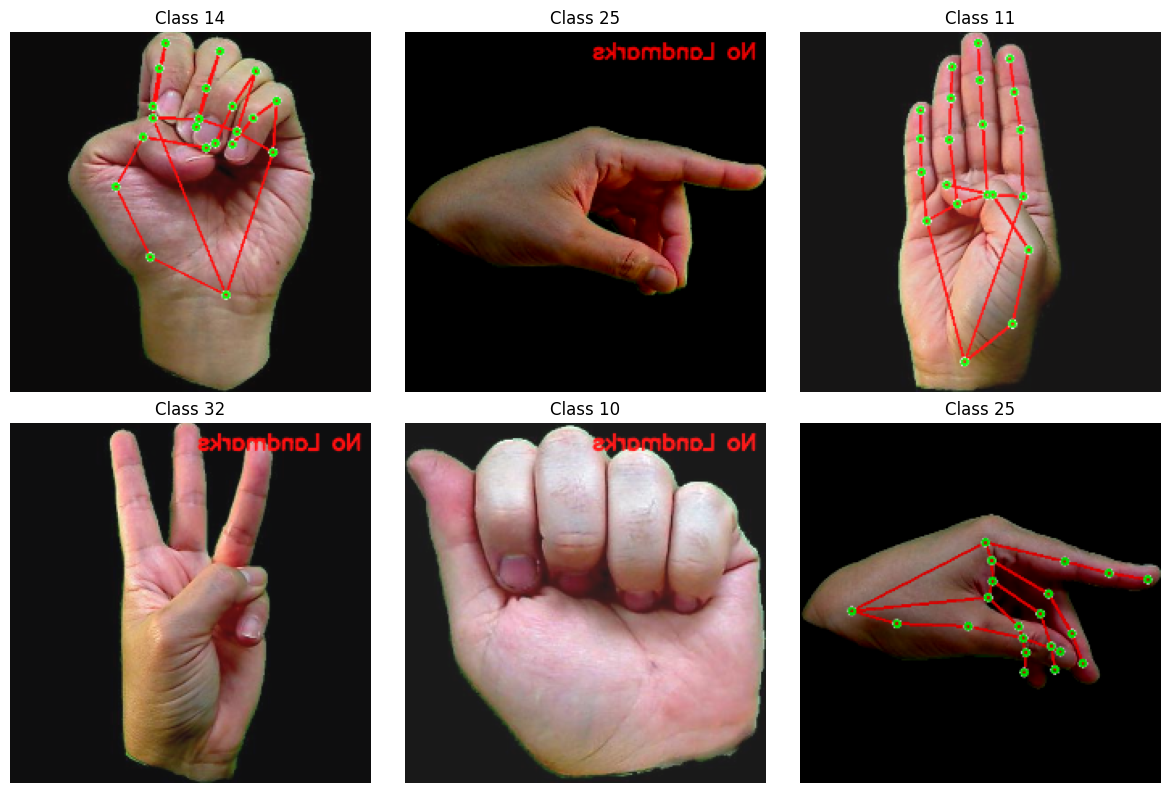

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

# -----------------------------------------------------
# MediaPipe Hands detector setup
# -----------------------------------------------------
mp_hands = mp.solutions.hands
# Lower detection confidence to catch more subtle poses
hands_detector = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3
)
mp_drawing = mp.solutions.drawing_utils

# -----------------------------------------------------
# 1. Preprocessing: extract & draw landmarks
# -----------------------------------------------------
def load_and_preprocess_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands_detector.process(img_rgb)

    # Always initialize a 63-element zero vector
    landmark_vector = np.zeros(63, dtype=np.float32)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        for i, lm in enumerate(hand_landmarks.landmark):
            landmark_vector[i*3 + 0] = lm.x
            landmark_vector[i*3 + 1] = lm.y
            landmark_vector[i*3 + 2] = lm.z
        # Draw landmarks if found
        mp_drawing.draw_landmarks(
            img_rgb,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=3),
            mp_drawing.DrawingSpec(color=(255,0,0), thickness=2)
        )
    else:
        # Optional: Draw "No Landmarks" on the image for visual debugging
        cv2.putText(img_rgb, "No Landmarks", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # Resize and normalize image
    img_out = cv2.resize(img_rgb, img_size)
    img_out = img_out.astype("float32") / 255.0

    return img_out, landmark_vector


# -----------------------------------------------------
# 2. Load paths & labels
# -----------------------------------------------------
def get_image_paths_and_labels(root_dir, categories):
    image_paths, labels = [], []
    for folder_name in sorted(os.listdir(root_dir)):
        if folder_name not in categories:
            continue
        folder_path = os.path.join(root_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for fname in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(categories[folder_name])

    if len(image_paths) == 0 or len(labels) == 0:
        print(f"Warning: No valid images or labels found in {root_dir}")

    return image_paths, labels
# -----------------------------------------------------
# 3. Build tf.data.Dataset
# -----------------------------------------------------
def create_tf_dataset(image_paths, labels, img_size=(224,224)):
    images, landmarks_list, valid_labels = [], [], []
    for p, lbl in zip(image_paths, labels):
        img, lms = load_and_preprocess_image(p, img_size)
        if img is not None:
            images.append(img)
            landmarks_list.append(lms)
            valid_labels.append(lbl)
    images = np.array(images, dtype="float32")
    landmarks_list = np.array(landmarks_list, dtype="float32")
    one_hot = keras.utils.to_categorical(valid_labels, num_classes=36)
    ds = tf.data.Dataset.from_tensor_slices(((images, landmarks_list), one_hot))
    return ds

# -----------------------------------------------------
# 4. Augmentation: photometric + landmark-aware flip
# -----------------------------------------------------
def augment_fn(inputs, label):
    image, landmarks = inputs
    # Photometric transforms
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Horizontal flip with landmark correction
    do_flip = tf.random.uniform([]) < 0.5
    def _flip():
        flipped_img = tf.image.flip_left_right(image)
        lm = tf.reshape(landmarks, (21,3))
        x, y, z = tf.unstack(lm, axis=1)
        x = 1.0 - x
        flipped_lm = tf.stack([x, y, z], axis=1)
        return flipped_img, tf.reshape(flipped_lm, (63,))
    def _no_flip():
        return image, landmarks
    image, landmarks = tf.cond(do_flip, _flip, _no_flip)

    return (image, landmarks), label

# -----------------------------------------------------
# 5. Prepare datasets
# -----------------------------------------------------
categories = {str(i): i for i in range(10)}
categories.update({chr(97 + i): 10 + i for i in range(26)})
root_dir = "/content/asl_dataset/asl_dataset"
paths, lbls = get_image_paths_and_labels(root_dir, categories)
train_p, test_p, train_l, test_l = train_test_split(
    paths, lbls, test_size=0.2, random_state=42, stratify=lbls
)

train_ds = create_tf_dataset(train_p, train_l)
test_ds  = create_tf_dataset(test_p, test_l)

train_ds = train_ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
BATCH_SIZE = 32
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -----------------------------------------------------
# 6. Visualize samples
# -----------------------------------------------------
for (imgs, lms), lbls in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(imgs[i].numpy())
        plt.title(f"Class {np.argmax(lbls[i])}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Clean up
hands_detector.close()


In [ ]:
import os
import tensorflow as tf

def build_model(lr, num_classes=36):
    # — Inputs —
    img_in = tf.keras.layers.Input(shape=(224,224,3), name="image_input")
    lm_in  = tf.keras.layers.Input(shape=(63,),      name="lm_input")

    # — Image branch (MobileNetV2) —
    base = tf.keras.applications.MobileNetV2(
        input_tensor=img_in,
        include_top=False,
        weights="imagenet"   # or None if you really want to train from scratch
    )
    base.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.3)(x)

    # — Landmark branch —
    y = tf.keras.layers.Dense(64, activation="relu")(lm_in)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(32, activation="relu")(y)

    # — Fuse & classify —
    z = tf.keras.layers.Concatenate()([x, y])
    z = tf.keras.layers.Dense(128, activation="relu")(z)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(z)

    model = tf.keras.Model(inputs=[img_in, lm_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
    )
    return model

def train(args):
    # data_builder must return (train_ds, val_ds),
    # where each element is ((img, landmark_vec), one_hot_label)
    train_ds, val_ds = data_builder(args)

    model = build_model(lr=args.lr, num_classes=36)
    model.summary()

    # Early stopping on val_loss, restore best weights
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    # Fit
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=args.epochs,
        callbacks=[early_stop],
        verbose=1
    )

    # Save
    save_path = os.path.join(args.path_to_model, "ASL_Classifier")
    model.save(save_path)
    print(f"Model saved to: {save_path}")

def test(args):
    # In test mode, data_builder returns just test_ds
    test_ds = data_builder(args)

    # Load & evaluate
    model = tf.keras.models.load_model(args.path_to_trained_model)
    results = model.evaluate(test_ds)
    print("Test loss & accuracy:", results)


In [ ]:
import os
import argparse
import sys
import tensorflow as tf
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split

# -------------------------
# Model Definition with added Dropout
# -------------------------

def build_model(lr, num_classes=36, dropout_image=0.5, dropout_landmark=0.3):
    img_in = tf.keras.layers.Input(shape=(224,224,3), name="image_input")
    base = tf.keras.applications.MobileNetV2(
        input_tensor=img_in,
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(dropout_image)(x)

    lm_in = tf.keras.layers.Input(shape=(63,), name="lm_input")
    y = tf.keras.layers.Dense(64, activation="relu")(lm_in)
    y = tf.keras.layers.Dropout(dropout_landmark)(y)
    y = tf.keras.layers.Dense(32, activation="relu")(y)

    z = tf.keras.layers.Concatenate()([x, y])
    z = tf.keras.layers.Dense(128, activation="relu")(z)
    z = tf.keras.layers.Dropout(0.3)(z)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(z)

    model = tf.keras.Model(inputs=[img_in, lm_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
    )
    return model

# -------------------------
# MediaPipe for Landmark Extraction
# -------------------------
mp_hands = mp.solutions.hands
hands_detector = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3
)

# -------------------------
# Data Loading & Preprocessing
# -------------------------

def load_and_preprocess(img_path, img_size=(224,224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None, False
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands_detector.process(img_rgb)

    lm_vec = np.zeros(63, dtype=np.float32)
    valid = False
    if results.multi_hand_landmarks:
        valid = True
        lm = results.multi_hand_landmarks[0]
        for i, l in enumerate(lm.landmark):
            lm_vec[i*3:(i*3+3)] = [l.x, l.y, l.z]

    img_resized = cv2.resize(img_rgb, img_size)
    img_norm = img_resized.astype('float32') / 255.0
    return img_norm, lm_vec, valid


def get_image_paths_and_labels(root_dir, categories):
    paths, labels = [], []
    for cls, idx in categories.items():
        p = os.path.join(root_dir, cls)
        if not os.path.isdir(p): continue
        for f in os.listdir(p):
            if f.lower().endswith(('.jpg','.png','.jpeg','bmp')):
                paths.append(os.path.join(p, f))
                labels.append(idx)
    return paths, labels


def create_dataset(paths, labels):
    imgs, lms, labs = [], [], []
    for p, l in zip(paths, labels):
        img, lm_vec, valid = load_and_preprocess(p)
        if img is None: continue
        imgs.append(img)
        lms.append(lm_vec)
        labs.append(l)
    imgs = np.array(imgs)
    lms = np.array(lms)
    onehot = tf.keras.utils.to_categorical(labs, num_classes=36)
    ds = tf.data.Dataset.from_tensor_slices(((imgs, lms), onehot))
    return ds

# -------------------------
# Training & Testing Function
# -------------------------

def run_train_test(root_dir, model_dir, lr, epochs, batch_size):
    categories = {str(i): i for i in range(10)}
    categories.update({chr(97+i):10+i for i in range(26)})

    paths, labels = get_image_paths_and_labels(root_dir, categories)
    p_train, p_temp, l_train, l_temp = train_test_split(
        paths, labels, test_size=0.3, stratify=labels, random_state=42
    )
    p_val, p_test, l_val, l_test = train_test_split(
        p_temp, l_temp, test_size=0.5, stratify=l_temp, random_state=42
    )

    train_ds = create_dataset(p_train, l_train).map(
        lambda x,y: (
            (tf.image.random_brightness(x[0],0.1), x[1]), y
        ), num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = create_dataset(p_val, l_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = create_dataset(p_test, l_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = build_model(lr)
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    model.fit(train_ds, validation_data=val_ds, epochs=epochs,
              callbacks=[es], verbose=1)

    print("Evaluating on test set...")
    results = model.evaluate(test_ds)
    print(f"Test Loss: {results[0]:.4f}, Test Acc: {results[1]:.4f}")

    os.makedirs(model_dir, exist_ok=True)
    save_path = os.path.join(model_dir, 'ASL_Classifier_fusion.keras')
    model.save(save_path)
    print(f"Model saved to {save_path}")

# -------------------------
# Main Execution (Colab & CLI)
# -------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str,
                        default='/content/asl_dataset/asl_dataset',
                        help='Root directory of ASL dataset')
    parser.add_argument('--model_dir', type=str, default='./model',
                        help='Directory to save the trained model')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='Learning rate')
    parser.add_argument('--epochs', type=int, default=100,
                        help='Number of training epochs')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Batch size')
    # Ignore unknown args (like Jupyter's -f flag)
    args, _ = parser.parse_known_args()

    print(f"Using data_dir: {args.data_dir}")
    run_train_test(
        root_dir=args.data_dir,
        model_dir=args.model_dir,
        lr=args.lr,
        epochs=args.epochs,
        batch_size=args.batch_size
    )


Using data_dir: /content/asl_dataset/asl_dataset


<ipython-input-2-537f9eef9624>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - acc: 0.0268 - loss: 4.0427 - val_acc: 0.1247 - val_loss: 3.3977
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.0449 - loss: 3.6875 - val_acc: 0.2281 - val_loss: 3.2214
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - acc: 0.0995 - loss: 3.3899 - val_acc: 0.3050 - val_loss: 3.0228
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.1243 - loss: 3.2409 - val_acc: 0.3846 - val_loss: 2.8145
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.1576 - loss: 3.0514 - val_acc: 0.4483 - val_loss: 2.5962
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - acc: 0.2031 - loss: 2.8878 - val_acc: 0.5279 - val_loss: 2.3684
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - acc: 0.2323 - loss: 2.6929 - val_acc: 0.5809 - val_loss: 2.1548
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - acc: 0.2894 - loss: 2.5372 - val_acc: 0.6631 - val_loss: 1.9566
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - 

In [ ]:
# Load model and test set
model = tf.keras.models.load_model('/content/model/ASL_Classifier.keras')

# Prepare test dataset
# Replace this with the actual test split you create if not done already
test_ds = create_tf_dataset(test_paths, test_labels, img_size=(224, 224))
test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# Evaluate
results = model.evaluate(test_ds, verbose=1)
print("Test results:", results)


NameError: name 'test_paths' is not defined

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompati

Model loaded successfully.
Capturing image from webcam...


<IPython.core.display.Javascript object>

Image captured.


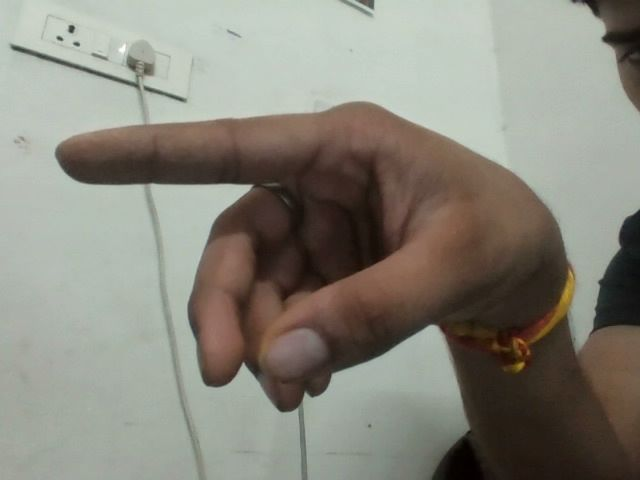

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted ASL label: p


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import mediapipe as mp

# -------------------------
# Load your trained model
# -------------------------
model = tf.keras.models.load_model('/content/ASL_Classifier_fusion.keras')
print("Model loaded successfully.")

# -------------------------
# Preprocessing: Extract landmarks & resize image
# -------------------------
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.3)

def preprocess_frame(frame, img_size=(224, 224)):
    # Convert to RGB and detect landmarks
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    # Prepare landmark vector (63 dims)
    landmark_vector = np.zeros(63, dtype=np.float32)
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        for i, lm in enumerate(hand_landmarks.landmark):
            landmark_vector[i*3 + 0] = lm.x
            landmark_vector[i*3 + 1] = lm.y
            landmark_vector[i*3 + 2] = lm.z
        # Optional: draw landmarks for visualization
        mp.solutions.drawing_utils.draw_landmarks(
            img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    else:
        print("Warning: No hand detected; using zero-vector landmarks.")

    # Resize & normalize image
    img_resized = cv2.resize(img_rgb, img_size)
    img_norm = img_resized.astype('float32') / 255.0

    return img_norm, landmark_vector

# -------------------------
# Webcam Capture
# -------------------------
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const captureButton = document.createElement('button');
            captureButton.textContent = 'Capture';
            div.appendChild(captureButton);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => captureButton.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    header, encoded = data.split(',', 1)
    image_data = np.frombuffer(b64decode(encoded), dtype=np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
    cv2.imwrite(filename, image)
    return image

# -------------------------
# Main Inference Flow
# -------------------------
print("Capturing image from webcam...")
captured = take_photo()
print("Image captured.")
cv2_imshow(captured)

# Preprocess: get image tensor & landmark vector
img_processed, lm_vector = preprocess_frame(captured)

# Prepare batch inputs
input_img = np.expand_dims(img_processed, axis=0)
input_lms = np.expand_dims(lm_vector, axis=0)

# Predict
probs = model.predict([input_img, input_lms])
pred_idx = np.argmax(probs, axis=1)[0]

# Map to ASL label
if pred_idx < 10:
    label = str(pred_idx)
else:
    label = chr(pred_idx - 10 + ord('a'))

print(f"Predicted ASL label: {label}")


In [ ]:
# Install required packages if not already installed.


import cv2
import numpy as np
import tensorflow as tf
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import mediapipe as mp

# -------------------------
# Load the TFLite model and initialize the interpreter
# -------------------------
tflite_model_path = "modelASL.tflite"  # Change this to your model filename if different.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("TFLite model loaded and interpreter allocated.")

# -------------------------
# Webcam Capture Function
# -------------------------
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const captureButton = document.createElement('button');
            captureButton.textContent = 'Capture';
            div.appendChild(captureButton);
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => captureButton.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    header, encoded = data.split(',', 1)
    image_data = np.frombuffer(b64decode(encoded), dtype=np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
    cv2.imwrite(filename, image)
    return image

# -------------------------
# Hand Detection using MediaPipe
# -------------------------
def detect_hand(image):
    # Convert image from BGR to RGB as required by MediaPipe.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True,
                        max_num_hands=1,
                        min_detection_confidence=0.5) as hands:
        results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        h, w, _ = image.shape
        x_coords = [int(landmark.x * w) for landmark in hand_landmarks.landmark]
        y_coords = [int(landmark.y * h) for landmark in hand_landmarks.landmark]
        # Compute bounding box with a little padding.
        x_min, x_max = max(min(x_coords) - 20, 0), min(max(x_coords) + 20, w)
        y_min, y_max = max(min(y_coords) - 20, 0), min(max(y_coords) + 20, h)
        hand_roi = image[y_min:y_max, x_min:x_max]
        return hand_roi, (x_min, y_min, x_max, y_max)
    else:
        print("No hand detected. Using full image.")
        return image, None

# -------------------------
# Capture Image and Detect Hand
# -------------------------
print("Capturing image from webcam...")
captured_image = take_photo()
print("Image captured.")
cv2_imshow(captured_image)

# Detect hand region in the captured image.
hand_image, bbox = detect_hand(captured_image)
if bbox:
    x_min, y_min, x_max, y_max = bbox
    image_with_box = captured_image.copy()
    cv2.rectangle(image_with_box, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    print("Detected hand region:")
    cv2_imshow(image_with_box)
else:
    print("No hand region detected; proceeding with full image.")

# -------------------------
# Preprocess the Cropped Hand Image
# -------------------------
# Resize image to 224x224 as expected by your model.
processed_image = cv2.resize(hand_image, (224, 224))
# Normalize pixel values to [0, 1].
processed_image = processed_image.astype('float32') / 255.0
# Expand dimensions to add the batch dimension.
input_data = np.expand_dims(processed_image, axis=0)

# -------------------------
# Run Inference with TFLite Interpreter
# -------------------------
# Set the tensor to point to the input data to be inferred.
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
# Get the model prediction.
predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(predictions)

# -------------------------
# Map the Predicted Index to an ASL Label
# -------------------------
if predicted_index < 10:
    predicted_label = str(predicted_index)
else:
    predicted_label = chr(predicted_index - 10 + ord('a'))

print("Predicted ASL label:", predicted_label)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


ValueError: Could not open 'modelASL.tflite'.

In [ ]:
import tensorflow as tf

# Load your TFLite model
tflite_model_path = "modelASL.tflite"  # Change to your actual model filename
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Print TensorFlow Lite version
print("TensorFlow Lite version:", tf.__version__)

# Check if metadata is available
if hasattr(interpreter, "get_signature_list"):
    print("Model Signatures:", interpreter.get_signature_list())
else:
    print("No model signature available. The model might be an older version.")


TensorFlow Lite version: 2.18.0
Model Signatures: {'serving_default': {'inputs': ['input_layer_9'], 'outputs': ['output_0']}}


In [ ]:
import tensorflow as tf

# If you have a .h5 file
model = tf.keras.models.load_model('/content/ASL_Classifier_fusion.keras')

# Or if you have a SavedModel directory
# model = tf.keras.models.load_model('path/to/saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpdxfhlpsl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 63), dtype=tf.float32, name='lm_input')]
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  137129902109136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129894267408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129902109904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129902112592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129902112016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129894267792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129894268560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129894266832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137129894266448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371298942689